## CNN모델 구현, 학습 및 결과 확인
> 간단한 CNN을 구현해보자. 먼저 필요한 모듈을 불러오고 hyperparameter를 설정하는 부분이다.

In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(DEVICE)

batch_size = 256
learning_rate = 0.0002
num_epoch = 10

cuda


- 새롭게 사용하는 모듈은 torch.utils.data에 있는 DataLoader모듈과 torchvision의 dataset, transforms이다.
- 모델을 학습하기 위해서는 지속적으로 데이터를 모델에 전달해야 한다. 또한 <font color=blue>데이터를 하나씩 전달하지 않고 원하는 batch_size대로 묶어서 전달하거나 더 효율적인 학습을 위해 데이터를 어떤 규칙에 따라 정렬하거나 섞거나 해야하는데</font>, 이런 역할을 해주는 것이 바로 <font color = gold>DataLoader</font>모듈이다!
- <font color = gold>torchvision</font>은 유명한 영상처리용 데이터셋, 모델, 이미지 변환기가 들어있는 패키지로서, 여기서 dataset모듈은 데이터를 읽어오는 역할, transforms는 불러온 이미지를 필요에 따라 변환해주는 역할을 한다.

In [23]:
mnist_train = dset.MNIST("./", train=True, transform=transforms.ToTensor(),
                         target_transform=None, download=True)
mnist_test = dset.MNIST("./", train=False, transform=transforms.ToTensor(),
                        target_transform=None, download=True)

train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size,
                                           shuffle=True,num_workers=2, drop_last=True)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size,
                                          shuffle=False, num_workers=2, drop_last=True)

1. MNIST 데이터 베이스
    - 가로 세로 길이 28의 숫자 이미지로 이루어진 데이터셋이다.
    - 각 숫자는 0부터 9까지 손으로 쓴 이미지이다.
    - dset.MNIST 함수에서 첫 번째 인수 : 데이터의 경로
        - 경로로 "./"를 사용했는데 이는 현재 코드가 있는 위치를 경로로 사용하겠다는 의미이다.
    - 두 번째 인수 : train
        - True를 넣으면 학습 데이터를 불러오고 False를 넣으면 테스트 데이터를 불러온다.
    - 세 번째 인수 : transform
        - 이미지에 대한 변형인데, 이미지 데이터를 파이토치 텐서로 변환하는 transforms.ToTensor()가 들어가 있다.
    - 네 번째 인수 : target_transform
        - 이미지에 해당하는 라벨에 대한 변형을 의미한다.
        - MNIST 데이터는 이미지와 그 이미지에 해당하는 라벨 카테고리 즉, 0~9까지 숫자 중 하나가 매칭이 되어 있다.
    - 마지막 인수 : download
        - 현재 경로에 MNIST 데이터가 없을 경우 다운로드하겠다는 의미이다. </br></br>

2. DataLoader 부분
    - dset.MNIST를 통해 정리된 데이터를 batch_size 개수만큼 묶는다는 의미이다.
    - 셔플 여부(shuffle), 데이터를 묶을 때 사용할 프로세스 개수(num_workers), 묶고 남는 데이터는 버릴지 여부(drop_last) 등에 대한 설정이다.

- 이렇게 생성된 train_loader와 test_loader는 순차적으로 모델에 데이터를 전달해준다.

***
***CNN 모델 생성**

In [24]:
class CNN(nn.Module) :
    def __init__(self) :
        super(CNN,self).__init__()
        self.layer = nn.Sequential(
            nn.Conv2d(1, 16, 5),
            nn.ReLU(),
            nn.Conv2d(16, 32, 5),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, 5),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.fc_layer = nn.Sequential(
            nn.Linear(64*3*3, 100),
            nn.ReLU(),
            nn.Linear(100, 10)
        )
    
    def forward(self, x) :
        out = self.layer(x)
        out = out.view(batch_size, -1)
        out = self.fc_layer(out)
        return out

- 클래스 안에 모델의 각 연산들이 정의되어 있고, 또한 forward함수에서 연산들을 순차적으로 실행하여 결과값만 리턴하도록 정의되어 있다.

- __init__함수에 있는 super클래스는 CNN클래스의 부모 클래스인 nn.Module을 초기화하는 역할을 한다.

- 합성곱 연산은 nn.Conv2d함수를 통해 이루어지는데, 인수로는 in_channels, out_channels, kernel_size, stride, padding등이 있다.
    - in_channels, out_channels : 앞서 합성곱 연산의 3차원적 이해에서 RGB 3 채널 데이터를 입력으로 받았던 것을 예로 들면 in_channels에는 3이 들어가게 되고, 필터의 개수가 out_channels에 들어가게 된다. 
    - 배치까지 포함된 텐서의 형태로 생각하면 입력은 [batch_size, in_channels, 가로, 세로]가 되고 합성곱 연산의 결과는 [batch_size, out_channels, 가로, 세로]가 된다.
    - 현재 사용하는 MNIST 데이터셋은 [batch_size, 1, 가로, 세로]의 형태이므로 CNN클래스에서 첫 번째 연산을 nn.Conv2d(1, 16, 5)로 설정하였다. -> in_channels = 1, out_channels = 16, kernel_size = 5
</br></br>
- [batch_size, 1, 28, 28]이었던 입력값은 첫 nn.Conv2d(1, 16, 5)연산을 통과하여 [batch_size, 16, 24, 24]가 된다.
    - 필터(패널)의 크기 K = 5, 패딩은 없으므로 P = 0, 스트라이드는 따로 설정하지 않았으므로 기본값 S = 1이다.

    ![CNN13](img/CNN13.png)

- 위의 결과 텐서를 활설 함수인 nn.ReLU()에 넣어준다. 이 과정을 다시 한번 반복하여 nn.Conv2d(16, 32, 5), nn.ReLU()연산을 통과하면 [batch_size, 32, 20, 20]이 된다.

- 그 다음에는 nn.MaxPool2d(2, 2)연산이 나온다. 이 연산은 인수로 kernel_size, stride, padding등을 받는다
    - kernel_size : 풀링 연산을 할 때 한 번에 훑는 영역의 크기이다. 하나의 숫자 k를 전달하면 kxk 영역에서 풀링한다.
    - stride : 이동거리</br>
    -> 예제처럼 kernel_size = 2, stride = 2를 전달하면 2x2 영역에서 풀링하고 2만큼 이동하므로, 연산 후에는 텐서가 반으로 줄어들게 된다! 결과적으로 텐서는 [batch_size, 32, 10, 10]의 크기가 된다.</br></br>

- 그 이후의 연산 nn.Conv2d(32, 64, 5), nn.ReLU(), nn.MaxPool2d(2, 2)가 실행되면 텐서의 크기는 [batch_size, 64, 6, 6] -> [batch_size, 64, 3, 3]이 된다!

- 그 다음부터는 인공 신경망에서 했던 것처럼 Linear함수를 통해 10개의 카테고리로 뉴런의 수를 줄여나간다.

- forward함수
    - [batch_size, 64, 3, 3] 형태의 텐서를 view함수를 통해 바꾸어준다.
    - view 함수에 인수로 목표하는 새로운 형태 [batch_size, -1]을 전달한다. 여기서 -1은 -1인 부분을 알아서 계산하라는 의미를 가진다.
    - 이렇게 형태를 바꾸어주는 이유는 합성곱 연산에서 요구되는 텐서의 형태와 Linear연산에서 요구되는 텐서의 형태가 다르기 때문이다.
    - 형태가 바뀐 텐서에 nn.Linear(64 * 3 * 3, 100), nn.ReLU(), nn.Linear(100, 10)연산을 차례대로 실행하면 [batch_size, 10] 형태의 텐서가 나온다.

***


- 이제 지금까지 봤던 코드처럼 모델을 초기화하고, '교차 엔트로피 손실 함수'를 지정하자.
- 최적화 함수로는 SGD를 사용해도 되지만, 새롭게 Adam알고리즘을 사용해보자.

In [25]:
model = CNN().to(DEVICE)
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [26]:
loss_arr = []

for i in range(num_epoch) :
    for j, [image,label] in enumerate(train_loader) :
        x = image.to(DEVICE)
        y = label.to(DEVICE)
        
        optimizer.zero_grad()
        output = model.forward(x)
        loss = loss_func(output, y)
        loss.backward()
        optimizer.step()
        
        if j % 1000 == 0 :
            print(loss)
            loss_arr.append(loss.cpu().detach().numpy())

tensor(2.3069, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.2120, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.1230, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0766, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0904, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0742, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0760, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0227, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0878, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0389, device='cuda:0', grad_fn=<NllLossBackward0>)


- enumerate()함수 : 인덱스와 원소를 동시에 접근하며 루프를 돌릴 수 있게 한다.
    - j가 인덱스(순서)를 담고, train 데이터의 image와 label을 각각 받아주었다.
    - image는 x에다가, label은 y에다가 저장하였다.</br></br>

- train_loader에서 image와 label쌍을 batch_size만큼 받아와서 모델에 전달하고, 손실을 계산하고, 손실에 대한 경사하강법을 진행하여 모델을 업데이트한다.

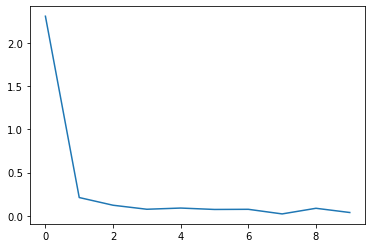

In [27]:
plt.plot(loss_arr)
plt.show()

- 학습 시의 손실을 시각화 한 것이다.

In [28]:
correct = 0
total = 0

with torch.no_grad() :
    for image, label in test_loader :
        x = image.to(DEVICE)
        y_ = label.to(DEVICE)
        
        output = model.forward(x)
        _, output_index = torch.max(output, 1)
        
        total += label.size(0)
        correct += (output_index == y_).sum().float()
        
    print("Accuracy of Test Data: {}".format(100*correct/total))

Accuracy of Test Data: 98.8681869506836


- 맞은 개수, 전체 개수를 담당할 변수를 각각 correct와 total로 지정하고 0으로 초기화한다.
- torch.no_grad()는 기울기를 계산하지 않는다는 의미이다. 이 조건하에 테스트를 진행한다.
- 모델에 test 데이터를 넣어서 나온 결과를 torch.max()함수를 이용하여 최댓값과 그 인덱스를 구한다.
    - output은 (batch_size x 10)'(배치 크기) x (클래스의 개수)'의 크기로 나올 것이다. 열은 클래스를 의미하므로, 최댓값을 갖는 열의 인덱스를 추출해낸 것이다.
- 그리고 그 인덱스가 정답 라벨과 일치하는지에 따라 correct변수에 더해준다.
- total변수에는 라벨의 형태(size)의 0번쨰 인덱스 값은 batch_size에 해당하기 때문에 이를 전부 더해준다.
- 모든 test 데이터를 모델에 통과하여 이 값들을 얻고, 마지막에 정확도를 출력한다.